# Statistical Modeling of Powerball data
There are three main steps to Statistical modeling:
- Write down the model
  - Prior and likelihood functions
- Compute the Posterior
  - Sampling or Inference
- Check the model
  - Prior Sensitivity
  - Reliability/accuracy in relation to observed data

A powerball ticket has five distinct numbers drawn from 1 to 69, and a sixth "powerball number" drawn independently. Here we are going to model the distribution of the smallest number in the powerball lottery tickets. 

In [77]:
%matplotlib inline
import theano
import pymc3 as pm
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons
import pandas as pd

## Load dataset
Peek into the data - curiosity helps build intuition
Intuition yields a prior (required for probabilistic modeling).


In [78]:
df = pd.read_csv('./pb/pb_asc_x1x5_x6.csv', header=None, names=['x1', 'x2', 'x3', 'x4', 'x5', 'x6'])
df.head()

,x1,x2,x3,x4,x5,x6
0,16,30,41,48,53,16
1,1,26,41,50,57,11
2,23,33,42,46,59,4
3,2,18,19,22,63,19
4,10,16,40,52,55,17


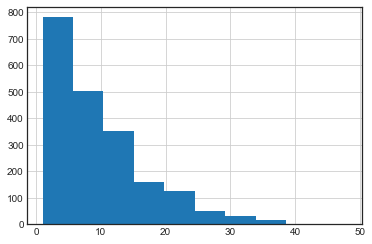

In [79]:
df_train['x1'].hist()

### Step 1 - Build the Model
The likelihood function is assumed to be a Geometric here. How did we arrive that? First study a list of probability functions, wikipedia is a great starter source. Then notice that our model has a definite support. What does that mean? That means the variable X1 is defined in a specific range. Also, X1 is discrete. So now one keeps rummaging for distributions that appear to have similar profile as the data we like to model including support and type.
In this case we find that Geometric distribution appears to fit the bill. It is definitely possible that one could other equally feasible probability distributions. In fact, that is part of the adventure of statistical modeling:
- positing the modeling question in interesting ways
- so as to find easily approximateable distributions

### Assume a Geometric distribution for the lowest number, X1
Use a Uniform Prior on the probability parameter

## Step 2 - Compute the Posterior
This is either done through sampling or inference. In case of MCMC family of sampling, the choices are - Metropolis, HMC, NUTS. 
Variational Inference converts the approximation problem into an optimization problem of minimizing KL Divergence between the posterior and a known suggested distribution _q_. Variational Inference, though was known for decades, recently got a boost from the recent techniques of Automatic Differentiation Variational Inference (ADVI). Variational Inferences are usually rapid, but suffer from accuracy.

Here we use NUTS sampler

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 5500/5500 [00:02<00:00, 2461.44it/s]


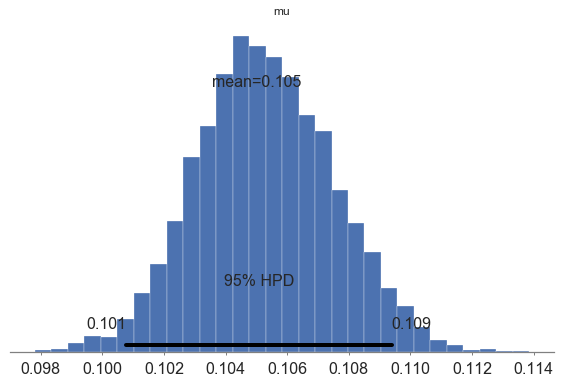

In [62]:
obs = df_train['x1']
with pm.Model() as zmodel:
    mu = pm.Uniform('mu', lower=0., upper=1.)
    zp_poisson = pm.Geometric('zp', p=mu, observed=obs)
    ztrace = pm.sample(5000)
    pm.plot_posterior(ztrace)


### Plot observed and simulated


100%|██████████| 5000/5000 [00:00<00:00, 15766.91it/s]


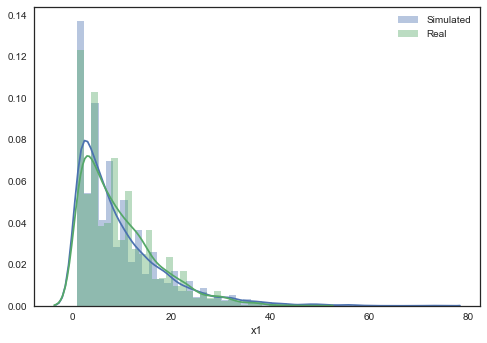

In [63]:
with zmodel:
    ppc = pm.sample_ppc(ztrace, 5000)
    sns.distplot(ppc['zp'], label='Simulated')
    sns.distplot(obs, label='Real')
    plt.legend()

## Step 3 - Check the Model
- Use the Posterior Predictive Check, ppc
- Plot observed and simulated
- Check model sensitivity to prior

### Prior sensitivity
- Same model with different priors (note the use of Beta distribution)
- Check the posterior with the previous posterior
- Notice the Highest Posterior Density region of the parameters(HPD)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 5500/5500 [00:02<00:00, 2293.12it/s]


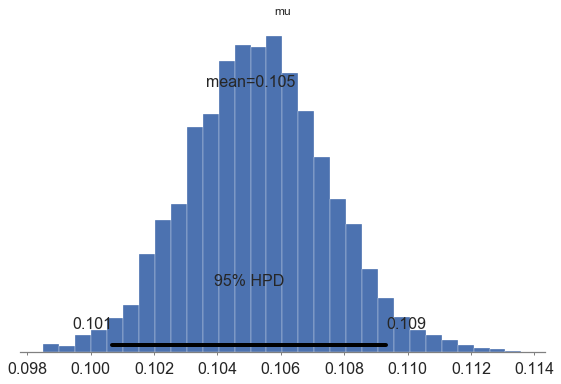

In [58]:
with pm.Model() as zmodel:
    mu = pm.Beta('mu', alpha=2, beta=2)
    zp_poisson = pm.Geometric('zp', p=mu, observed=obs)
    ztrace = pm.sample(5000)
    pm.plot_posterior(ztrace)


**__That posterior is the same as the previous one (except for minor numerical precision differences)__**
It further confirms / validates our model.
Now, one could apply the same model for each of x2, x3, x4, and x5, with varying discrete intervals as support.
For x6 we could consider a categorical distribution (or a similar BetaBinomial as for x1-x5).

100%|██████████| 5000/5000 [00:00<00:00, 15101.64it/s]


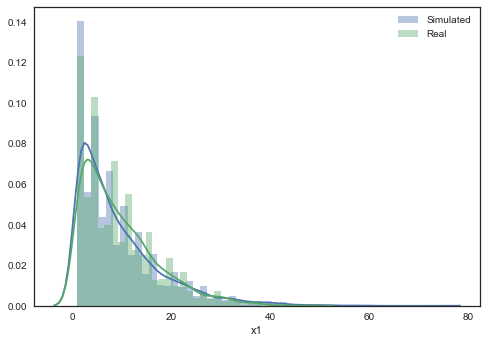

In [59]:
with zmodel:
    ppc = pm.sample_ppc(ztrace, 5000)
    sns.distplot(ppc['zp'], label='Simulated')
    sns.distplot(obs, label='Real')
    plt.legend()

In [61]:
#Divergences
ztrace['diverging'].nonzero()[0].size * 1.0 / len(ztrace)

0.0

In [77]:
# Posterior mean
chosen_x1 = ppc['zp'].argsort()[::-1]
ppc['zp'].mean().round()

10.0

### Use a Random Forest
Given X1, predict X2

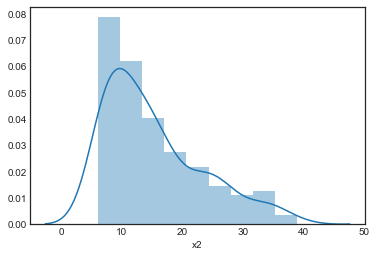

In [67]:
from sklearn.ensemble import RandomForestRegressor

#plt.plot(df_train.loc[df_train['x1']==1]['x1'], df_train.loc[df_train['x1'] ==1]['x2'])
sns.distplot(df.loc[df_train['x1']==5]['x2'])



In [ ]:
from sklearn.model_selection import train_test_split
df = df.sample(frac=1).reset_index(drop=True)
X_train, X_test, y_train, y_test = train_test_split(df['x6'], df['x1'], test_size=0.1)
X_train = np.reshape(X_train, (-1, 1))
y_train = np.reshape(y_train, (-1, 1))
X_test = np.reshape(X_test, (-1,1))
y_test = np.reshape(y_test, (-1, 1)) 

X_train, y_train, X_test, y_test

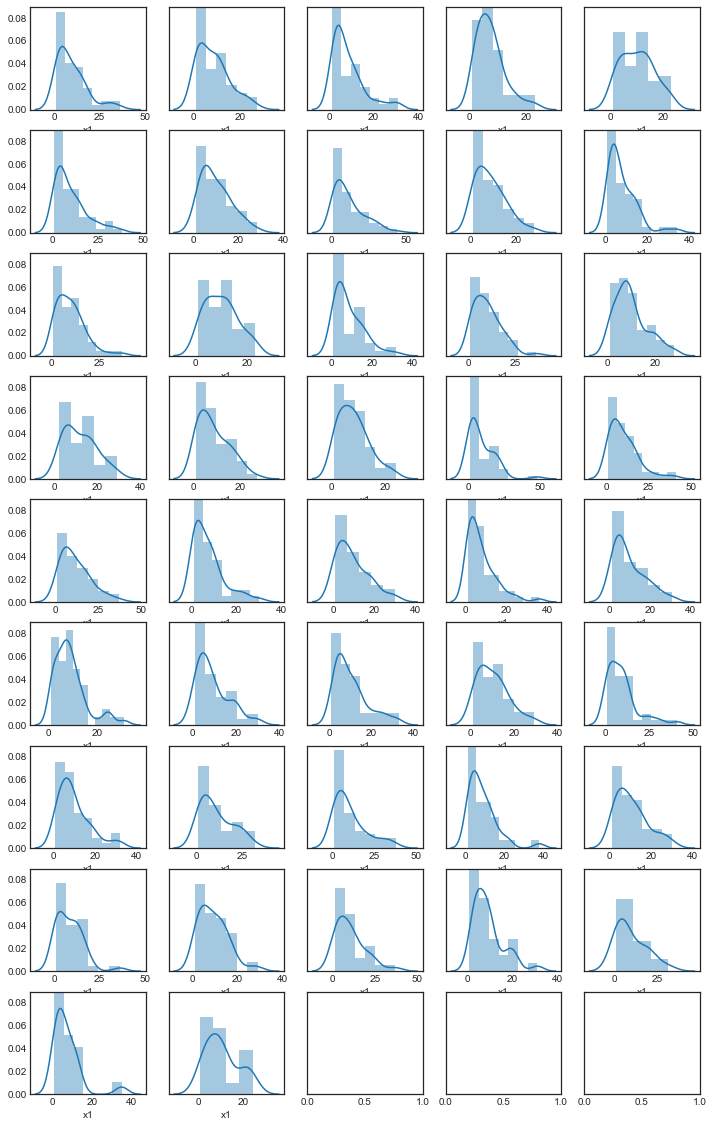

In [174]:
fig, ax = plt.subplots(9, 5, figsize=(12, 20), sharey=True)
for i in range(0, 42):
    sns.distplot(df.loc[df['x6']==i+1]['x1'], ax=ax[i//5, i%5])


In [114]:
rf_reg = RandomForestRegressor(max_depth=10, n_estimators=20)
rf_reg.fit(X_train, y_train)
y_ = np.round(rf_reg.predict(X_test))
y_ = np.reshape(y_, (-1, 1))
y_.shape, X_test.shape, y_test.shape, X_train.shape, y_train.shape, 


((203, 1), (203, 1), (203, 1), (1819, 1), (1819, 1))

In [134]:
#Within an epsilon distance
epsilon = 1
sum(np.sum((abs(y_ - y_test) <= epsilon), axis=1)) * 100./y_.shape[0]

13.300492610837438

In [136]:
X_train.max(), X_train.min(), y_train.max(), y_train.min()

(42, 1, 48, 1)

### Log transformed in and out
Transform x6 and x1 by np.log

In [ ]:
X_train, y_train, X_test, y_test = np.log(X_train), np.log(y_train), \
    np.log(X_test), np.log(y_test)
    

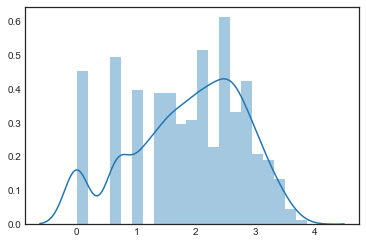

In [170]:
sns.distplot(y_train)

In [172]:
y_train.min()
#sns.distplot(np.log(y_train))

0.0

In [152]:

rf_reg = RandomForestRegressor(max_depth=10, n_estimators=200)
rf_reg.fit(X_train, y_train)
y_ = rf_reg.predict(X_test)
y_ = np.reshape(y_, (-1, 1))
#y_.shape, X_test.shape, y_test.shape, X_train.shape, y_train.shape, 


In [156]:
import math
#Within an epsilon distance
epsilon = math.e
sum(np.sum((abs(y_ - y_test) <= epsilon), axis=1)) * 100./y_.shape[0]

100.0

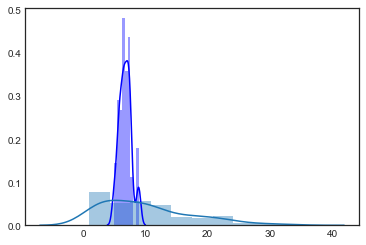

In [154]:
sns.distplot(np.exp(y_), color='b')
sns.distplot(np.exp(y_test))

In [164]:
#np.sqrt(np.sum(np.sum((y_ - y_test)**2, axis=1)))
#np.sum((y_ - y_test)**2, axis=1)
np.mean(y_ - y_test), np.var(y_ - y_test), np.max(y_ - y_test), np.min(y_ - y_test)

(-0.080423472160005699,
 0.77486730020034478,
 2.0219894797995424,
 -1.6140088267463986)

### Prepare the data
Training data consists of X1, X2 pairs
Also split the data into train and test

In [95]:
from sklearn.cross_validation import train_test_split
def prepare_data(df):
    X_data = df[['x1', 'x2']]
    
    #Shuffle
    X_data = X_data.sample(frac=1).reset_index(drop=True)

    #split - train, test
    X_train, X_test, y_train, y_test = train_test_split(X_data['x1'], X_data['x2'], test_size=0.01)
    X_train = np.reshape(X_train, (-1, 1))
    X_test = np.reshape(X_test, (-1, 1))
    y_train = np.reshape(y_train, (-1, 1))
    y_test = np.reshape(y_test, (-1, 1))
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prepare_data(df_train)

array([[10],
       [ 8],
       [ 9],
       [18],
       [10],
       [12],
       [ 6],
       [36],
       [ 3],
       [ 8],
       [17],
       [ 1],
       [13],
       [ 9],
       [ 6],
       [13],
       [ 5],
       [ 8],
       [ 1],
       [ 2],
       [ 3]])

### Plot the training data (X2)

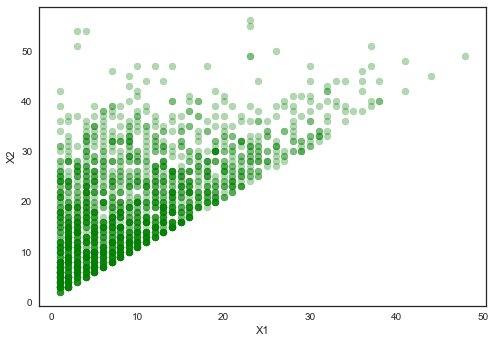

In [104]:
fig, ax = plt.subplots()
ax.scatter(X_train, y_train, color='g', alpha=0.3)
plt.xlabel('X1'); plt.ylabel('X2')

_This makes sense of course, since X2 >= X1_

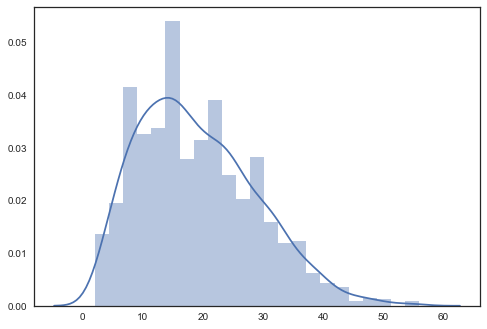

In [102]:
sns.distplot(y_train)
plt.legend()


In [121]:
xrange = np.arange(X_train.min(), X_train.max() + 1)
fig, ax = plt.subplots()
ax.plot(X_train[arange])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

### Define a model for X2
Assuming BetaBinomial, discrete distribution with support over positive integers
The model for X2 will be a Bayesian Neural Net conditioned on the value of X1
The prior for the X2's support \{0..n\}  and it's alpha and beta are dependent on X1

In [207]:
ntrain = len(X_train)

#Construct the NN
def construct_nn(nn_in, nn_out):
    n_hidden = 5
    init_1 = np.random.randn(1, n_hidden).astype(theano.config.floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(theano.config.floatX)
    init_3 = np.random.randn(n_hidden, 1).astype(theano.config.floatX)
    
    with pm.Model() as bnn:
        a = pm.Uniform('a', lower=0.4, upper=5.)
        b = pm.Uniform('b', lower=2., upper=8.)
        c = pm.Uniform('c', lower=1., upper=60.)
        
        weights_1 = pm.Normal('w_1', mu=0, sd=1, shape=(1, n_hidden), testval=init_1)
        weights_2 = pm.Normal('w_2', mu=0, sd=1, shape=(n_hidden, n_hidden), testval=init_2)
        weights_3 = pm.Normal('w_3', mu=0, sd=1, shape=(n_hidden, 1), testval=init_3)
        
        #Activations
        act_1 = pm.math.tanh(pm.math.dot(nn_in, weights_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_2))
        act_3 = pm.math.sigmoid(pm.math.dot(act_2, weights_3))
        
        print("{}, {}, {},".format(act_3.tag.test_value.shape, act_3.shape, type(act_3)))
        print("{}".format(act_3.tag.test_value[:,0].mean()))
#         print("{}".format(act_3.tag.test_value[:,1].mean()))
#         print("{}".format(act_3.tag.test_value[:,2].mean()))
#         a = pm.Deterministic('a', act_3.tag.test_value[:,0].mean())
#         b = pm.Deterministic('b', act_3.tag.test_value[:,1].mean())
#         c = pm.Deterministic('c', act_3.tag.test_value[:,2].mean())
        out = pm.BetaBinomial('x2pred', 
                              alpha=a, 
                              beta=b,
                              n=tt.round(c),
                              observed=nn_out, 
                              total_size=ntrain)
        
    return bnn

### Fit the model to data (Inference)
Uses ADVI to compute the posterior distribution of parameters

In [208]:
nn_in = theano.shared(X_train)
nn_out = theano.shared(y_train)
bnn = construct_nn(nn_in, nn_out)
with bnn:
    # inference = pm.ADVI()
    approx = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


(2001, 1), Shape.0, <class 'theano.tensor.var.TensorVariable'>,
0.282729815524


  0%|          | 0/1500 [00:00<?, ?it/s]


ValueError: Bad initial energy: inf. The model might be misspecified.

In [ ]:
with bnn:
    pm.plot_posterior(approx)


# Miscellaneous
## A Zero Truncated Poisson
__Custom Probability Distribution in PyMC3__

In [39]:
import theano.tensor as tt
from theano import function
from theano import printing
import pymc3 as pm

class ZeroTruncatedPoisson(pm.Discrete):
    '''
    Similar to a Poisson distribution, but the support is over positive integes 
    and so, excludes zero. An example, number of items in your grocery shopping cart
    at checkout
    '''
    def __init__(self, mu, *args, **kwargs):
        super(ZeroTruncatedPoisson, self).__init__(*args, **kwargs)
        self.mu = tt.as_tensor_variable(mu)
    
    def logp(self, value):
        '''
        compute total_log_probability
        '''
        return tt.sum(value * tt.log(self.mu) - tt.log(tt.exp(self.mu) -1) - tt.gammaln(value))
    
    def random(self, point=None, size=None):
        '''
        Generates a random sample from Zero Truncated Poisson
        '''
        k = 1
        mu = self.mu.tag.test_value
        t = tt.exp(-self.mu)/(1 - tt.exp(-self.mu))/(1. * self.mu)
        tn = t.tag.test_value
        s = tn
        u = np.random.uniform()
        while s < u:
            k = k + 1
            tn = tn * mu / k
            s = s + tn
            u = np.random.uniform()
        return k

In [ ]:
# If using a ZeroTruncatedPoisson
# obs = df_train['x1']
# with pm.Model() as zmodel:
#     mu = pm.HalfNormal('mu', sd=10.)
#     zp_poisson = ZeroTruncatedPoisson('zp', mu=mu, observed=obs)
#     ztrace = pm.sample(1000)
#     pm.plot_posterior(ztrace)


In [145]:
import numpy as np
import theano.tensor as tt
from theano import function
#tt.config.compute_test_value = 
x = tt.dscalar('x')
y = tt.dscalar('y')
z = x + y
tt.pprint(z)
add = function([x, y], z)
n1 = add(402., 1)
type(n1)
#n1
with pm.Model() as mmodel:
    a1 = 
    w1 = pm.Normal('w1', mu=0., sd=1., shape=(1, 2))
    a2 = pm.math.dot(a1, w1)


numpy.ndarray

In [ ]:
k = np.array([1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,48,1])
import theano.tensor as tt
def ztp_logp(k):
    return tt.sum(k * tt.log(lam) - tt.log(tt.exp(lam) - 1) - tt.gammaln(k))

ztp_logp(k)


In [185]:
vm1 = np.random.randn(1, 5).astype(theano.config.floatX)
type(vm1)
#vm1.shape
vm2= halfnorm.rvs(size=(1,5)).astype(theano.config.floatX)
type(vm2)
vm2.shape
X_train[0].shape
nn_in.shape


Shape.0

### Define the neural network

### Plot the posterior parameter distribution from 5000 samples

In [ ]:
with bnn:
    trace = approx.sample(draws=5000)
    pm.traceplot(trace)

### Plot the learnt boundary against training data

In [ ]:
with bnn:
    rpc = pm.sample_ppc(trace, 500)
    rpred = rpc['Category'].mean(axis=0)
    #rproba = rpc['Category'].std(axis=0)
    fig, ax = plt.subplots()
    ax.scatter(X_train[rpred > 0.5], rpred[rpred > 0.5], color='b', alpha=0.01)
    ax.scatter(X_train[rpred <= 0.5], rpred[rpred <= 0.5], color='r', alpha=0.01)
    ax.scatter(X_train[y_train], y_train[y_train], color='g', alpha=0.01)
    ax.scatter(X_train[~y_train], y_train[~y_train], color='k', alpha=0.01)

#### Plot the Evidence Lower Bound (ELBO) maximization history

In [ ]:
with bnn:
    plt.plot(-inference.hist, label='ADVI', color='b', alpha=0.4)
    plt.xlabel('Iteration')
    plt.ylabel('ELBO')

**__What is the functional form of the neural net?__**
<p>
The neural net computes the probability parameter of a Bernoulli distribution based on a series of non-linearities and affine transformations of the input

In [ ]:
bnn.Category.distribution

### Now time to predict (Posterior Predictive Check) 

In [ ]:
nn_in.set_value(X_test)
nn_out.set_value(y_test)
with bnn:
    ppc = pm.sample_ppc(trace, 500)
    pred = ppc['Category'].mean(axis=0)
    proba = ppc['Category'].std(axis=0)

### Plot the predictions

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred > 0.5], pred[pred > 0.5])
ax.scatter(X_test[pred <= 0.5], pred[pred <= 0.5], color='r', alpha=0.2)
ax.scatter(X_test[y_test], y_test[y_test], color='c', alpha=0.1)
ax.scatter(X_test[~y_test], y_test[~y_test], color='c', alpha=0.1)

print('Accuracy: {}'.format( ( y_test == (pred > 0.5) ).mean() * 100 ))

### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
cm = [ 1 if x > 0.5 else 0 for x in pred ]
cnf = confusion_matrix(cm, y_test)
sns.heatmap(cnf, annot=True, fmt='d', cmap='PiYG')

In [ ]:
cnf

### Now the uncertainty in prediction

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.errorbar(X_test[pred > 0.5], pred[pred > 0.5], yerr = proba[pred > 0.5], fmt='o', ecolor='g', capthick=2, alpha=0.1)
ax.errorbar(X_test[pred <= 0.5], pred[pred <= 0.5], yerr = proba[pred <= 0.5], 
            fmt='o', ecolor='r', color='y', capthick=2, alpha=0.1)

## Comparison to a Gaussian Process classifier

In [ ]:
%%time
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

gp_clf = GaussianProcessClassifier(1.0 * RBF(1.0))
nsize=1000
gp_clf.fit(X_train[:nsize,:], y_train[:nsize,:])
#clf.fit(X_train, y_train)

**__Phew.... that took for ever. Especially in comparison to BNN__**

In [ ]:
%%time
print gp_clf.score(X_test, y_test)
xx = np.arange(1,70)
pp = gp_clf.predict_proba(xx.reshape(-1,1))
fig, ax = plt.subplots()
ax.scatter(xx, pp[:,1], color='r')

## Compare to a random forest classifier

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
rf_clf.fit(X_train, y_train)

In [ ]:
%%time
print (rf_clf.score(X_test, y_test))
xx = np.arange(1,70)
pp = rf_clf.predict_proba(xx.reshape(-1,1))
fig, ax = plt.subplots()
ax.scatter(xx, pp[:,1], color='r')

## Compare to AdaBoosted Decision Trees

In [ ]:
%%time
from sklearn.ensemble import AdaBoostClassifier
ad_clf = AdaBoostClassifier()
ad_clf.fit(X_train, y_train)

In [ ]:
%%time
print (ad_clf.score(X_test, y_test))
xx = np.arange(1, 70)
pp = ad_clf.predict_proba(xx.reshape(-1,1))
fig, ax = plt.subplots()
ax.scatter(xx, pp[:,1], color='r')

## Miscellaneous

In [ ]:
with pm.Model():
    bs = pm.BetaBinomial('betasample', alpha=3., beta=4., n=50)
    bstrace = pm.sample(10000)
    pm.plot_posterior(bstrace)

In [ ]:
sns.distplot(df_train['x6'])